In [1]:
%matplotlib inline

import pyxem as px
from diffsims import generators
import tensorflow as tf
import diffpy.structure
from matplotlib import pyplot as plt
import numpy as np
import os
import hyperspy as hs
from tqdm import tqdm

os.chdir('E:\Elisabeth\SPED-phase-mapping')
from ANN import preprocess as pp
from ANN import training_data_functions as tdf

from keras.models import load_model

## Load and preprocess experimental data, load tensorflow model

In [2]:
signal = hs.io.load('Data/datasetA_preprocessed.hspy')

In [3]:
rot_angle = -60.33
mask_size = 11
shift = 0.032
nx, ny, kx, ky = signal.axes_manager[0].size, signal.axes_manager[1].size, signal.axes_manager[2].size, signal.axes_manager[3].size
signal_masked = pp.preprocess_NN(signal, rot_angle, mask_size, shift)

Rotating data..
[########################################] | 100% Completed | 52.65 s
Scaling the intensity..


100%|███████████████████████████████████████████████████████████████████████| 262144/262144 [00:20<00:00, 13032.35it/s]


Normalizing between 0 and 1..


100%|███████████████████████████████████████████████████████████████████████| 262144/262144 [00:06<00:00, 42461.58it/s]


In [4]:
directory = r'Data/Outputs'
model = load_model(directory + r'/ANN_trained_model')

### Predict

128/128 [==============================] - 24s 179ms/step


100%|██████████████████████████████████████████████████████████████████████| 262144/262144 [00:01<00:00, 260108.68it/s]


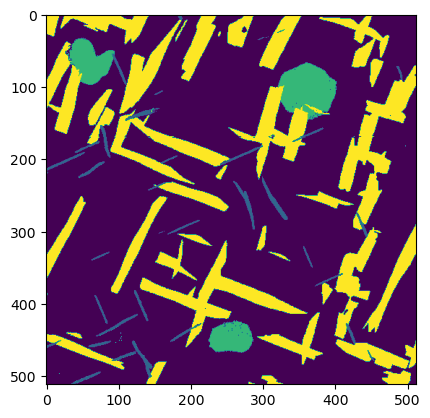

In [5]:
nx, ny = signal.data.shape[0], signal.data.shape[1]
kx, ky = signal.data.shape[2], signal.data.shape[3]

predictions = model.predict(signal_masked, batch_size=2048)
signal_prediction = np.zeros((nx*ny))
for i in tqdm(range(nx*ny)):
    signal_prediction[i] = np.argmax(predictions[i])
signal_prediction = signal_prediction.reshape(nx, ny)
plt.close('all')
plt.imshow(signal_prediction)

In [6]:
phase_map_ANN = hs.signals.Signal2D(signal_prediction)
phase_map_ANN.save(r'Data/Outputs/datasetA_phase_map_ANN.hspy')

Overwrite 'E:\Elisabeth\SPED-phase-mapping\Data\Outputs\datasetA_phase_map_ANN.hspy' (y/n)?
 y


### Optionally: Test values for log-shift:

In [ ]:
import gc

shift_array = np.arange(0.028 , 0.038, 0.001)
mask_size = 11
errors = np.zeros_like(shift_array)
ground_truth = hs.io.load(r'E:\Elisabeth\SPED-phase-mapping\Data\Outputs\ground_truth.hspy')

for ind, shift in enumerate(shift_array):
    signal_masked = pp.preprocess_NN(signal, rot_angle, mask_size, shift)
    print('predicting..')
    predictions = model.predict(signal_masked, batch_size=2048)
    signal_prediction = np.zeros((nx*ny))
    print('creating phase map')
    for pixel in tqdm(range(nx*ny)):
        signal_prediction[pixel] = np.argmax(predictions[pixel])
    signal_prediction = signal_prediction.reshape(nx, ny)
    phase_map_ANN = hs.signals.Signal2D(signal_prediction)
    error = np.count_nonzero(np.abs((phase_map_ANN-ground_truth).data))/(512*512)
    errors[ind] = error
    print('Error: {}% when shift = {}'.format(error*100, shift))
    del signal_masked
    gc.collect()

limit = 0.00001
index = np.ma.MaskedArray(errors, errors < limit)
index = np.ma.argmin(index)
print('Lowest error: {}% when shift = {}'.format(errors[index]*100, shift_array[index]))